# Winter Project: News Headlines for Sarcasm Detection (NLP Binary Classification)
**Objective:** To classify headlines as either sarcastic or not sarcastic.

In [2]:
# upload the json file with the sarcastic headlines dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data?select=Sarcasm_Headlines_Dataset_v2.json
from google.colab import files


uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


In [3]:
# general import statements
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import io
import tensorflow as tf
import torch.utils.data as data_utils
from sklearn.metrics import classification_report

# read the json file and load contents into a dataframe
df = pd.read_json(io.BytesIO(uploaded['Sarcasm_Headlines_Dataset_v2.json']), lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
# data cleaning: remove the article link column to prevent bias
df.drop(columns="article_link", axis=1, inplace=True)
df.head(5)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [5]:
# data cleaning: remove null rows to prevent syntactical errors
df = df.dropna()
df = df.drop_duplicates()
print(len(df))

28503


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
# install transformers
!pip install transformers

In [8]:
# do a train-validation-test-split of 80-10-10
from sklearn.model_selection import train_test_split

df = df.sort_values(by=['is_sarcastic'])

train_df, X_rem, tr_labels, y_rem = train_test_split(df['headline'], df['is_sarcastic'], stratify = df['is_sarcastic'],
                                                  train_size=0.80)
val_df, test_df, v_labels, te_labels = train_test_split(X_rem,y_rem, stratify = y_rem,
                                                    test_size=0.50)


# get the lists of train/test/validation headlines and their labels
train_headlines = train_df.values
train_labels = tr_labels.values

val_headlines = val_df.values
val_labels = v_labels.values

test_headlines = test_df.values
test_labels = te_labels.values


print("TRAIN SIZE")
print(len(train_headlines))

print("VAL SIZE")
print(len(val_headlines))


print("TEST SIZE")
print(len(test_headlines))

TRAIN SIZE
22802
VAL SIZE
2850
TEST SIZE
2851


In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Print the original headline.
print(' Original: ', train_headlines[0])

# Print the headline split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_headlines[0]))

# Print the headline mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_headlines[0])))

 Original:  rachel maddow claims new audio damning enough to pad out entire week's worth of shows
Tokenized:  ['rachel', 'mad', '##do', '##w', 'claims', 'new', 'audio', 'damn', '##ing', 'enough', 'to', 'pad', 'out', 'entire', 'week', "'", 's', 'worth', 'of', 'shows']
Token IDs:  [5586, 5506, 3527, 2860, 4447, 2047, 5746, 4365, 2075, 2438, 2000, 11687, 2041, 2972, 2733, 1005, 1055, 4276, 1997, 3065]


In [11]:
max_len = 0

# For every headline...
for head in train_headlines:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(head, add_special_tokens=True)

    # Update the maximum headline length.
    max_len = max(max_len, len(input_ids))

# For every headline...
for head in val_headlines:

    # Tokenize the headline and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(head, add_special_tokens=True)

    # Update the maximum headline length.
    max_len = max(max_len, len(input_ids))

# For every headline...
for head in test_headlines:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(head, add_special_tokens=True)

    # Update the maximum headline length.
    max_len = max(max_len, len(input_ids))

print('Max headline length: ', max_len)

Max headline length:  193


In [12]:
# Tokenize all of the headlines and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every headline...
for head in train_headlines:

    encoded_dict = tokenizer.encode_plus(
                        head,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded headline to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

# Print headline 0, now as a list of IDs.
print('Original: ', train_headlines[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  rachel maddow claims new audio damning enough to pad out entire week's worth of shows
Token IDs: tensor([  101,  5586,  5506,  3527,  2860,  4447,  2047,  5746,  4365,  2075,
         2438,  2000, 11687,  2041,  2972,  2733,  1005,  1055,  4276,  1997,
         3065,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [13]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# set the training dataset and initialize the batch size
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

# Create the DataLoader for the training set using random samples of batches
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

In [14]:
# Tokenize all of the headlines and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every headline...
for head in val_headlines:

    encoded_dict = tokenizer.encode_plus(
                        head,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded headline to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(val_labels)

# Print headline 0, now as a list of IDs.
print('Original: ', val_headlines[0])
print('Token IDs:', input_ids[0])

Original:  voice inside cheering libyan rebel's head: 'oh, fuck, now what?'
Token IDs: tensor([  101,  2376,  2503, 24867, 19232,  8443,  1005,  1055,  2132,  1024,
         1005,  2821,  1010,  6616,  1010,  2085,  2054,  1029,  1005,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [15]:
# initialize the validation dataset with a batch size
val_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

# use sequential order for the dataloader (randomization does not matter here)
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Define the Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

total_steps = len(train_dataloader) * epochs

# Learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [19]:
import numpy as np

# Function to calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
import random
import numpy as np


# initialize training variables and store statistics
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from the dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 0 the gradients
        model.zero_grad()

        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        # Get the loss and "logits" output by the model.
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches to
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of validation headlines, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    713.    Elapsed: 0:00:13.
  Batch    80  of    713.    Elapsed: 0:00:25.
  Batch   120  of    713.    Elapsed: 0:00:37.
  Batch   160  of    713.    Elapsed: 0:00:49.
  Batch   200  of    713.    Elapsed: 0:01:01.
  Batch   240  of    713.    Elapsed: 0:01:13.
  Batch   280  of    713.    Elapsed: 0:01:25.
  Batch   320  of    713.    Elapsed: 0:01:38.
  Batch   360  of    713.    Elapsed: 0:01:50.
  Batch   400  of    713.    Elapsed: 0:02:03.
  Batch   440  of    713.    Elapsed: 0:02:15.
  Batch   480  of    713.    Elapsed: 0:02:28.
  Batch   520  of    713.    Elapsed: 0:02:41.
  Batch   560  of    713.    Elapsed: 0:02:54.
  Batch   600  of    713.    Elapsed: 0:03:06.
  Batch   640  of    713.    Elapsed: 0:03:19.
  Batch   680  of    713.    Elapsed: 0:03:32.

  Average training loss: 0.27
  Training epcoh took: 0:03:43

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.19
  Validation took: 0:00:10

====

In [22]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.27,0.19,0.92,0:03:43,0:00:10
2,0.13,0.23,0.92,0:03:53,0:00:10
3,0.06,0.28,0.93,0:03:54,0:00:10
4,0.03,0.33,0.93,0:03:53,0:00:10


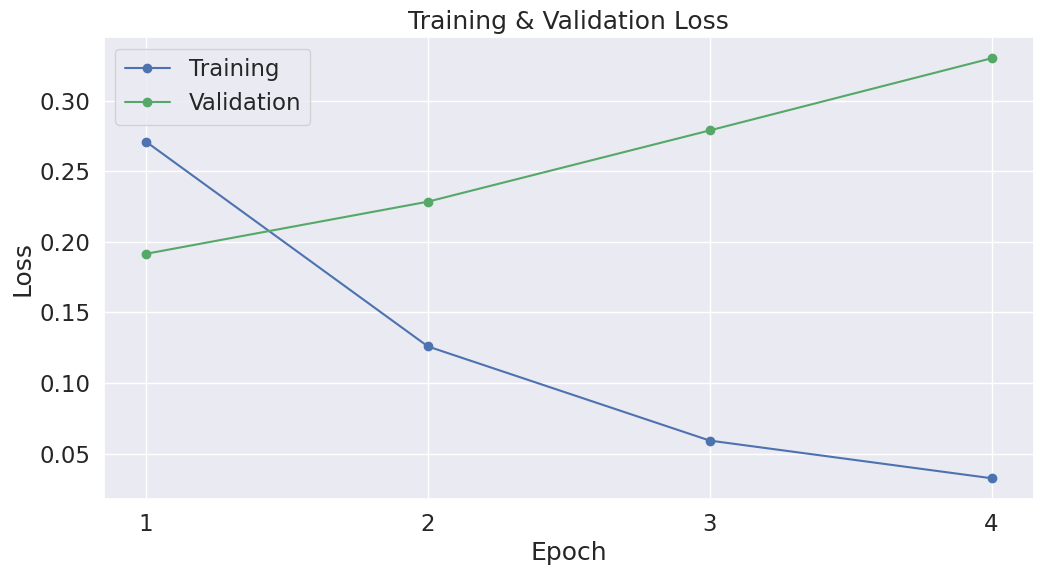

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [26]:
# Tokenize all of the headlines and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every headline...
for head in test_headlines:

    encoded_dict = tokenizer.encode_plus(
                        head,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded headline to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Print headline 0, now as a list of IDs.
print('Original: ', test_headlines[0])
print('Token IDs:', input_ids[0])

Original:  adult film industry replaces 500 porn stars with hydraulic robotic fisting arm
Token IDs: tensor([  101,  4639,  2143,  3068, 20736,  3156, 22555,  3340,  2007, 14761,
        20478,  7345,  2075,  2849,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [27]:
# initialize test dataset and batch size
test_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32


# Create the prediction DataLoader, pulling out sequential samples
prediction_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [29]:
# Prediction on test set

print('Predicting labels for {:,} test headlines...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,851 test headlines...
    DONE.


In [30]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-31-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


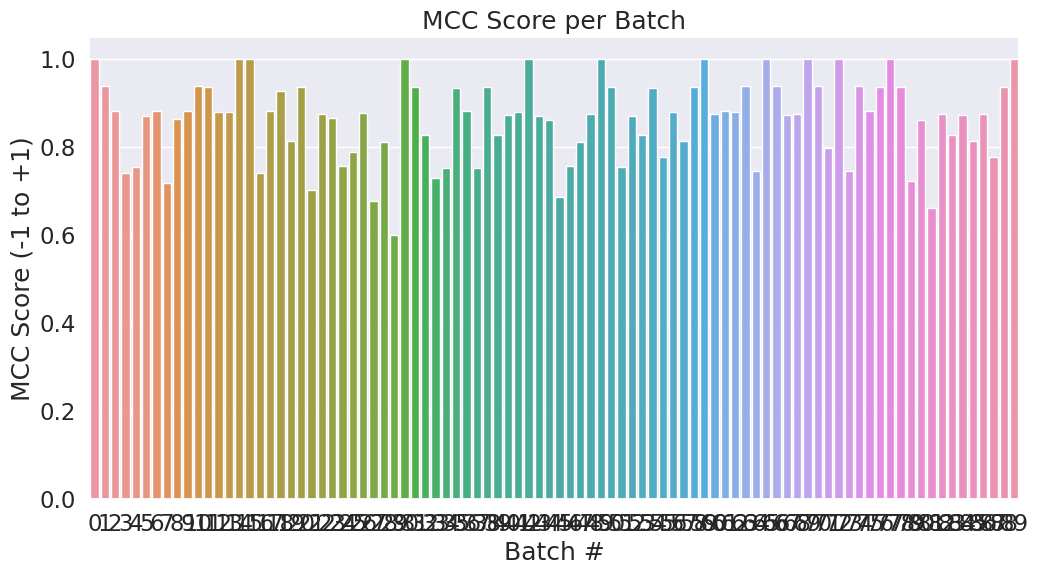

In [31]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [32]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.863


In [35]:
# print the overall metrics report (precision, recall, f1-score, accuracy)
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1495
           1       0.95      0.91      0.93      1356

    accuracy                           0.93      2851
   macro avg       0.93      0.93      0.93      2851
weighted avg       0.93      0.93      0.93      2851

